## Check where this runs
***

In [1]:
import os
os.environ["our_new"] = ""
envs = os.getenv("LOGNAME")
print(envs)
assert envs == "hughharford"
# if you get an error here, the notebook is not running in HSTH's expected place, and adjusts will be required.
print(os.environ)
if envs == "hughharford":
    environment_running = 'laptop'
else:
    environment_running = 0

hughharford
environ({'BUNDLER_EDITOR': 'code', 'CHROME_DESKTOP': 'code-url-handler.desktop', 'COLORTERM': 'truecolor', 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus', 'DESKTOP_SESSION': 'ubuntu', 'DISPLAY': ':0', 'EDITOR': 'code', 'ELECTRON_NO_ATTACH_CONSOLE': '1', 'GDK_BACKEND': 'x11', 'GDMSESSION': 'ubuntu', 'GNOME_DESKTOP_SESSION_ID': 'this-is-deprecated', 'GNOME_SETUP_DISPLAY': ':1', 'GNOME_SHELL_SESSION_MODE': 'ubuntu', 'GNOME_TERMINAL_SCREEN': '/org/gnome/Terminal/screen/f6e8b67a_2b75_44ec_9dbe_a7686b561fe4', 'GNOME_TERMINAL_SERVICE': ':1.99', 'GTK_MODULES': 'gail:atk-bridge', 'HOME': '/home/hughharford', 'HOMEBREW_NO_ANALYTICS': '1', 'LANG': 'en_US.UTF-8', 'LANGUAGE': 'en_GB:en', 'LC_ALL': 'en_US.UTF-8', 'LESS': '-R', 'LOGNAME': 'hughharford', 'LSCOLORS': 'Gxfxcxdxbxegedabagacad', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.

# IMPORTS
***

In [2]:
import os
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
import dask.dataframe as dd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  

if not environment_running == 'laptop':
    %pip install seaborn
    # no seaborn by default in AWS SageMaker.
    
import seaborn as sns

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

## Establish paths

In [4]:
# check raw data archive path extant:
atp_data_path = os.path.join('..','raw_data','archive')
assert os.path.exists(atp_data_path)

# set read_data path for chunking later on:
read_data_path = os.path.join('..','raw_data','read_data')
assert os.path.exists(read_data_path) 

# check initial data file expected are extant:
matches_data_path_full = os.path.join(atp_data_path, 'all_matches.csv')
assert os.path.exists(matches_data_path_full)

# Show getting 50k rows works:

In [5]:
# this works to convert dates as reading in. good news
schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)

/tmp/ipykernel_29624/2131584680.py:3: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None).astype(schema)


In [6]:
matches_df_1st_50k.dtypes.head()
# this confirms astype(schema) works, so date manipulation is available

start_date       datetime64[ns]
end_date         datetime64[ns]
location                 object
court_surface            object
prize_money             float64
dtype: object

In [7]:
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

# Organise for broad categories of column

In [8]:
# keep a simple dict of columns to see how full they are
# could use a simple .count() but going to run across mutiple chunks, and only want to see specific columns
check_completeness = {'start_date': 0, 'end_date': 0, 'player_name': 0, 
                      'duration': 0
                      }
check_key_distinguishing_columns = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0,}
check_numerical_columns = {'prize_money': 0,'sets_won': 0,'games_won': 0,  
                           'games_against': 0, 'tiebreaks_won': 0,  'tiebreaks_total': 0,
                      'serve_rating': 0, 'aces': 0, 
                      'double_faults': 0, 'first_serve_made': 0, 
                      'first_serve_attempted': 0, 'first_serve_points_made': 0,  
                      'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                      'second_serve_points_attempted': 0, 'break_points_saved': 0, 
                      'break_points_against': 0, 'service_games_won': 0, 
                      'return_rating': 0, 'first_serve_return_points_made': 0, 
                      'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                      'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                      'break_points_attempted': 0, 'return_games_played': 0, 
                      'service_points_won': 0, 'service_points_attempted': 0, 
                      'return_points_won': 0, 'return_points_attempted': 0, 
                      'total_points_won': 0, 'total_points': 0, 
                      'duration': 0, 
                      # distinguishing column:
                      'round_num': 0
                      }
check_mixed_columns = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0}
check_boolean_columns = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0}

In [9]:
# queries 
single_date_query = {"start_date > 2010": 0}
single_year_query = {"year > 2010": 0}


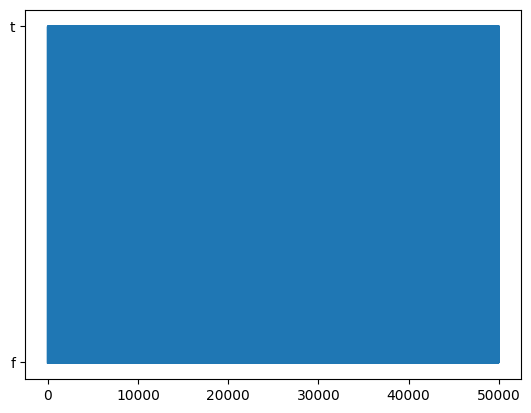

In [10]:
plt.plot(matches_df_1st_50k.player_victory);

### Boolean transformer, can apply to many columns

In [11]:

boolean_transformer = Pipeline([
    ('fill_empties', SimpleImputer(strategy='constant', missing_values=np.nan, fill_value="empty")),
    ('impute_t_is_true', SimpleImputer(strategy='constant', missing_values="t", fill_value=True)),
    ('impute_f_is_false', SimpleImputer(strategy='constant', missing_values="f", fill_value=False)),
])

In [12]:
# Create preprocessor with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('bools', boolean_transformer, list(check_boolean_columns.keys())),
        
    ],remainder='passthrough'
    )

In [13]:
preprocessor # check preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('bools',
                                 Pipeline(steps=[('fill_empties',
                                                  SimpleImputer(fill_value='empty',
                                                                strategy='constant')),
                                                 ('impute_t_is_true',
                                                  SimpleImputer(fill_value=True,
                                                                missing_values='t',
                                                                strategy='constant')),
                                                 ('impute_f_is_false',
                                                  SimpleImputer(fill_value=False,
                                                                missing_values='f',
                                                                strategy='constant'))]),
                                 ['player_victory', 'retirement',
                                  'won_first_set'])])

In [14]:
# Build the pipeline with the different steps
pipe = Pipeline([
    ('preprocessor', preprocessor),
])

### Prepare, so can tell if pipeline worked as intended: 

In [15]:
matches_df_1st_50k[check_boolean_columns.keys()].head()


,player_victory,retirement,won_first_set
0,f,f,f
1,t,f,t
2,f,f,f
3,f,f,t
4,t,f,t


## Apply Pipeline:

In [16]:
matches_booleans = pipe.fit_transform(matches_df_1st_50k) 


In [17]:
matches_booleans

array([[False, False, False, ..., 100, 1, 'Slovakia'],
       [True, False, True, ..., 100, 0, 'Slovakia'],
       [False, False, False, ..., 100, 3, 'Slovakia'],
       ...,
       [True, False, True, ..., 25, 6, 'DEN'],
       [True, False, True, ..., 25, 4, 'DEN'],
       [True, False, True, ..., 25, 5, 'DEN']], dtype=object)

In [18]:
# convert back into dataframe, with (updated) column headings
matches_booleans = pd.DataFrame(
    matches_booleans,
    columns=preprocessor.get_feature_names_out()
).convert_dtypes().head()

In [19]:
matches_booleans.head()

,bools__player_victory,bools__retirement,bools__won_first_set,remainder__start_date,remainder__end_date,remainder__location,remainder__court_surface,remainder__prize_money,remainder__currency,remainder__year,...,remainder__return_points_won,remainder__return_points_attempted,remainder__total_points_won,remainder__total_points,remainder__duration,remainder__seed,remainder__doubles,remainder__masters,remainder__round_num,remainder__nation
0,False,False,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,...,16,44,32,88,01:02:00,NaN,f,100,1,Slovakia
1,True,False,True,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,...,38,91,101,195,02:43:00,NaN,f,100,0,Slovakia
2,False,False,False,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,...,28,72,56,126,01:17:00,NaN,f,100,3,Slovakia
3,False,False,True,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,...,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,t,100,4,Slovakia
4,True,False,True,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,...,31,90,100,194,02:32:00,1,f,100,3,Slovakia


In [20]:
matches_booleans.columns

Index(['bools__player_victory', 'bools__retirement', 'bools__won_first_set',
       'remainder__start_date', 'remainder__end_date', 'remainder__location',
       'remainder__court_surface', 'remainder__prize_money',
       'remainder__currency', 'remainder__year', 'remainder__player_id',
       'remainder__player_name', 'remainder__opponent_id',
       'remainder__opponent_name', 'remainder__tournament', 'remainder__round',
       'remainder__num_sets', 'remainder__sets_won', 'remainder__games_won',
       'remainder__games_against', 'remainder__tiebreaks_won',
       'remainder__tiebreaks_total', 'remainder__serve_rating',
       'remainder__aces', 'remainder__double_faults',
       'remainder__first_serve_made', 'remainder__first_serve_attempted',
       'remainder__first_serve_points_made',
       'remainder__first_serve_points_attempted',
       'remainder__second_serve_points_made',
       'remainder__second_serve_points_attempted',
       'remainder__break_points_saved', 'remaind

In [21]:
original_cols = [c.split("__")[1] for c in matches_booleans.columns]
zipper = zip(matches_booleans.columns, original_cols)
print(original_cols)

['player_victory', 'retirement', 'won_first_set', 'start_date', 'end_date', 'location', 'court_surface', 'prize_money', 'currency', 'year', 'player_id', 'player_name', 'opponent_id', 'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won', 'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total', 'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 'service_games_won', 'return_rating', 'first_serve_return_points_made', 'first_serve_return_points_attempted', 'second_serve_return_points_made', 'second_serve_return_points_attempted', 'break_points_made', 'break_points_attempted', 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 'return_points_attempted', 'total_points_won', 'total_points', 'duration', 'seed', 'doubles', 'masters', 'ro

In [22]:
# updated_after_pipe__to_before = {i: old_name for i, old_name in enumerate(zipper)} # new_cols, matches_booleans.columns.values
updated_after_pipe__to_before = {i: old_name for i, old_name in zipper} # new_cols, matches_booleans.columns.values

In [23]:
# updated_after_pipe__to_before # remove comment to check outcome is as intended

In [24]:
matches_booleans = matches_booleans.rename(columns=updated_after_pipe__to_before)
matches_booleans.columns

Index(['player_victory', 'retirement', 'won_first_set', 'start_date',
       'end_date', 'location', 'court_surface', 'prize_money', 'currency',
       'year', 'player_id', 'player_name', 'opponent_id', 'opponent_name',
       'tournament', 'round', 'num_sets', 'sets_won', 'games_won',
       'games_against', 'tiebreaks_won', 'tiebreaks_total', 'serve_rating',
       'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted',
       'first_serve_points_made', 'first_serve_points_attempted',
       'second_serve_points_made', 'second_serve_points_attempted',
       'break_points_saved', 'break_points_against', 'service_games_won',
       'return_rating', 'first_serve_return_points_made',
       'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
    

In [25]:
matches_booleans.dtypes.head()

player_victory           boolean
retirement               boolean
won_first_set             object
start_date        datetime64[ns]
end_date          datetime64[ns]
dtype: object

In [26]:
# check_numerical_columns - got to deal with these too
subset_1st_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'prize_money','sets_won','games_won',  
                           'games_against','tiebreaks_won','tiebreaks_total','round_num'}}
subset_2nd_numerical = {k: check_numerical_columns[k] for k in check_numerical_columns.keys() & {'serve_rating', 'aces', 'double_faults', 'first_serve_made', 'first_serve_attempted', 
                                                                                                 'first_serve_points_made', 'first_serve_points_attempted', 'second_serve_points_made', 
                                                                                                 'second_serve_points_attempted', 'break_points_saved', 'break_points_against', 
                                                                                                 'service_games_won', 'return_rating', 'first_serve_return_points_made', 
                                                                                                 'second_serve_return_points_attempted', 'first_serve_return_points_attempted', 
                                                                                                 'second_serve_return_points_made', 'break_points_made', 'break_points_attempted', 
                                                                                                 'return_games_played', 'service_points_won', 'service_points_attempted', 'return_points_won', 
                                                                                                 'return_points_attempted', 'total_points_won', 'total_points', 'duration'}}


In [27]:
# NOTED DOWN FROM ATP SITE 24 06 25 (need to understand if % or float etc) => columns in existing data
# - Aces => aces
# - 1st Serve => first_serve_made
# - 1st Serve points won => first_serve_points_made
# - 2nd Serve => second_serve_points_made
# - 2nd Serve points won => second_serve_points_made
# - Service Games won => service_games_won
# - Break Points saved => break_points_saved
# - 1st Serve Return Points won => first_serve_return_points_made
# - 2nd Serve Return Points won => second_serve_return_points_made
# - Break Points Converted => break_points_made
# - Return Games won => ???

In [32]:
data_atp_provide_col_subset = ['aces', 'first_serve_made', 'first_serve_points_made', 
                    'second_serve_points_made', 'second_serve_points_made', 
                    'service_games_won', 'break_points_saved', 
                    'first_serve_return_points_made', 'second_serve_return_points_made', 'break_points_made']

# Run through full dataset

In [ ]:
# REFACTOR HERE! >>>>>>>>>>>>>>>>>>>>>>>>>>>>> 

# to go through all the sample data set
if run_through_hefty_EDA_cells:
    
    start = time.time()
    ave_bytes = 0
    count = 0
    total_bytes = 0

    # this works to convert dates as reading in. good news
    schema = {'start_date': 'datetime64[ns]', 'end_date': 'datetime64[ns]'}

    csv_files = get_count_csvs(read_data_path)          
    if len(csv_files) == 0:
        chunk_count = 0
        # This enumerate function selects repeated chunks of XXX rows of data 
        for index, read_chunk in enumerate(pd.read_csv(matches_data_path_full
                                                    , chunksize= 100_000
                                                    # usecols = list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                                    #, parse_dates=True
                                                    ),
                                            start=1):
            chunk_count += 100_000
            print(f"{index} so done with {chunk_count}")
            # output
            output_path = os.path.join(read_data_path,f"read_data_{index}.csv")
            read_chunk.to_csv(output_path, index=False)
        
    csv_files = get_count_csvs(read_data_path) # get the files now created
    for index, csv in enumerate(csv_files): # read back in in manageable quantities, with astype etc
        chunk = pd.read_csv(csv, index_col=None).astype(schema)
        this_bytes = chunk.memory_usage().sum()
        total_bytes += this_bytes
        # count data points and accumulate in the various dicts
        check_completeness = check_through_count(chunk, check_completeness)
        check_key_distinguishing_columns = check_through_count(chunk, check_key_distinguishing_columns)
        check_numerical_columns = check_through_count(chunk, check_numerical_columns)
        check_mixed_columns = check_through_count(chunk, check_mixed_columns)
        check_boolean_columns = check_through_count(chunk, check_boolean_columns)
        date_query_result = count_by_date(chunk, single_date_query)
        na_check = na_count(chunk, na_checks)

    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
    ave_bytes = total_bytes / index
    print(f"Average MB per loop: {round(ave_bytes/100_000,0):,}")
    print(check_completeness)

    print(round(time.time() - start,2), ' seconds')

    # Total number of chunks: 43 ______________________ of 100_000 rows
    # Total memory, MB: 18,558.0
    # Average MB per loop: 432.0
    # {'start_date': 4395827, 'end_date': 4295393, 'player_name': 375001, 'duration': 372823}
    # 72.15  seconds